In [132]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [99]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',') 

In [100]:
#all columns
data_all.head()

,INITIAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,41,91.0,50.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,12,401.0,389.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,8,308.0,300.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,12,668.0,656.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,16,271.0,255.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


***INCLUDING IMPORTANT FEATURES ONLY***

In [101]:
data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')

In [102]:
#df without dispatch response seconds
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,91.0,50.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,401.0,389.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,308.0,300.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,668.0,656.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,271.0,255.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [103]:
data.shape

(100000, 603)

***BINNING INCIDENT_TRAVEL_TM (DISCRETIZING)***

In [104]:
#bins; change n to change num of bins
n = 5 
max = 1025
bin_width = max/n #+1 because we have n bins so n+1 endpoints
bin_width

205.0

In [105]:
#bin ranges
bins = np.linspace(0,max,n+1)
bins

array([   0.,  205.,  410.,  615.,  820., 1025.])

In [106]:
#labels for bin ranges
labels = list(range(1,n+1))
labels

[1, 2, 3, 4, 5]

In [107]:
#df to visualize bins
df = pd.DataFrame(data = labels)
df['start'] = bins[:bins.shape[0]-1]
df['end'] = bins[1:]
df

,0,start,end
0,1,0.0,205.0
1,2,205.0,410.0
2,3,410.0,615.0
3,4,615.0,820.0
4,5,820.0,1025.0


In [108]:
#coding continuous data based on bins/labels, removing continuous data cols
data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin
0,3,91.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7,401.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
2,3,308.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,4,668.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
4,6,271.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [109]:
import collections
from collections import Counter

In [110]:
travel_tm = collections.Counter(data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
travel_tm_count = sum(travel_tm.values())
travel_tm

Counter({1: 11678, 2: 44078, 4: 11164, 3: 28610, 5: 4470})

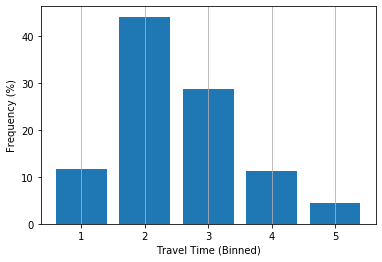

In [111]:
#visualize count of data within each bin
travel_tm = {k: (v*100) / travel_tm_count for k, v in travel_tm.items()} #mult by 100 to turn into percent
plt.bar(travel_tm.keys(),travel_tm.values())
plt.grid(axis = 'x')
plt.xlabel("Travel Time (Binned)")
plt.ylabel("Frequency (%)")
plt.show()

***SPLITTING TRAIN / TEST***

In [112]:
#X is predictors, Y is value to be predicted
X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

In [113]:
X.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,91.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,401.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,308.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,668.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,271.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [114]:
Y.head()

0    1
1    2
2    2
3    4
4    2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [115]:
#splitting into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

In [116]:
X_train.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
61219,2,298.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12400,7,498.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83016,4,499.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16447,6,917.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1617,2,308.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [117]:
Y_train.head()

61219    2
12400    3
83016    3
16447    5
1617     2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [118]:
X_test.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
98642,2,419.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
27361,6,660.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
73632,6,632.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86211,2,340.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3278,5,254.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [119]:
Y_test.head()

98642    2
27361    4
73632    3
86211    2
3278     2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

***LINEAR DISCRIMINANT ANALYSIS***

In [120]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [121]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [122]:
lda.score(X_train,Y_train)

0.94536

In [123]:
lda.score(X_test,Y_test)

0.93944

In [124]:
Y_lda_predict = lda.predict(X_test)
Y_lda_predict

array([2, 4, 4, ..., 3, 2, 1])

In [133]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_lda_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.93      0.90      0.92      2984
           2       0.94      0.96      0.95     10971
           3       0.94      0.93      0.94      7176
           4       0.93      0.93      0.93      2768
           5       0.95      0.96      0.95      1101

    accuracy                           0.94     25000
   macro avg       0.94      0.93      0.94     25000
weighted avg       0.94      0.94      0.94     25000



In [134]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_lda_predict))

=== Confusion Matrix ===
[[ 2686   298     0     0     0]
 [  200 10510   261     0     0]
 [    0   351  6668   157     0]
 [    0     0   139  2570    59]
 [    0     0     0    49  1052]]


***KNN***

In [126]:
from sklearn.neighbors import KNeighborsClassifier

In [127]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [128]:
knn.score(X_train, Y_train)

0.9576

In [129]:
knn.score(X_test, Y_test)

0.94392

In [130]:
Y_knn_predict = knn.predict(X_test)
Y_knn_predict

array([2, 4, 4, ..., 3, 2, 1])

In [136]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_knn_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.95      0.91      0.93      2984
           2       0.95      0.95      0.95     10971
           3       0.94      0.94      0.94      7176
           4       0.92      0.94      0.93      2768
           5       0.94      0.96      0.95      1101

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000



In [137]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_knn_predict))

=== Confusion Matrix ===
[[ 2723   261     0     0     0]
 [  157 10465   349     0     0]
 [    0   239  6751   186     0]
 [    0     0   100  2606    62]
 [    0     0     0    48  1053]]


***Result Comparison***

In [131]:
result = pd.DataFrame(data =Y_test)
result['LDA'] = Y_lda_predict
result['KNN'] = Y_knn_predict
result.head()

,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin,LDA,KNN
98642,2,2,2
27361,4,4,4
73632,3,4,4
86211,2,2,2
3278,2,2,2


error rate, lift